# Tutorial: Plasmonic directional nanoantenna optimization

Here we use [`pyGDM`](https://homepages.laas.fr/pwiecha/pygdm_doc) together with [`nevergrad`](https://facebookresearch.github.io/nevergrad/) to optimize a plasmonic nanoantenna for directional emission of an attached quantum emitter.

This tutorial aims at reproducing the generat trend in [Wiecha et al. Opt. Express 27, pp. 29069, (2019)](https://doi.org/10.1364/OE.27.029069). However, for runtime and readibility of the notebook, we keep the configuration simpler. The nanoantenna is made from smaller and fewer gold elements, the antenna is placed in a homogeneous environment (air) and the emitter is *above* the antenna, such that we do not need to add a forbidden zone constraint in the material positioning.

In [ ]:
# install dependecies
!pip install pygdm2
!pip install nevergrad
!pip install tqdm

## load modules

In [1]:
import nevergrad as ng
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import linear
from pyGDM2 import tools
from pyGDM2 import visu

## preparation define geometry parametrization & cost functions

We start by defining the geometric model helper and the cost function

In [2]:
def setup_structure(XY_coords_blocks, element_sim):
    """helper to create structure, from positions of gold elements
    each positions in units of discretization steps

    Args:
        XY_coords_blocks (list): list gold element positions (x1,x2,x3,...,y1,y2,....)
        element_sim (`pyGDM2.core.simulation`): single element simulation
        
    Returns:
        pyGDM2.structures.struct: instance of nano-geometry class
    """
    
    n = len(XY_coords_blocks) // 2
    x_list = XY_coords_blocks[:n]
    y_list = XY_coords_blocks[n:]
    pos = np.transpose([x_list, y_list])
    
    struct_list = []
    for _p in pos:
        x, y = _p
        # displace by steps of elementary block-size
        _s = element_sim.struct.copy()
        DX = _s.geometry[:, 0].max() - _s.geometry[:, 0].min() + _s.step
        DY = _s.geometry[:, 1].max() - _s.geometry[:, 1].min() + _s.step
        _s = structures.shift(_s, np.array([DX*int(x), DY*int(y), 0.0]))
        
        # do not add the block if too close to emitter at (0,0) 
        if np.abs(x) >= 1 or np.abs(y) >= 1:
            struct_list.append(_s)
    
    if len(struct_list) == 0:
        struct_list.append(_s + [DX, DY, 0])  # add at least one block
    
    full_struct = structures.combine_geometries(struct_list, step=element_sim.struct.step)
    full_sim = element_sim.copy()
    full_sim.struct = full_struct
    return full_sim


# ------- the optimization target function -------
def cost_direct_emission(x, element_sim, method, verbose=0):
    """ cost function: maximize scattering towards small solid angle

    Args:
        x (list): optimization params --> pos of elements
        element_sim (`pyGDM2.core.simulation`): single element simulation
        method (str): pyGDM2 solver method

    Returns:
        float: 1 - Reflectivity at target wavelength
    """
    sim = setup_structure(x, element_sim)
    sim.scatter(method=method, verbose=verbose)
    
    ## 2D scattering evaluation in upper hemisphere
    warnings.filterwarnings('ignore')
    Nteta, Nphi = 18, 32
    NtetaW, NphiW = 4, 5
    Delta_angle = np.pi * 10/180   # +/- 10 degrees target angle
    I_full = linear.farfield(
        sim, field_index=0, return_value='int_Etot',
        phimin=0, phimax=2*np.pi,
        tetamin=0, tetamax=np.pi/2,
        Nteta=Nteta, Nphi=Nphi)
    I_window = linear.farfield(
        sim, field_index=0, return_value='int_Etot',
        phimin=-np.pi/6, phimax=np.pi/6 + (np.pi/3)/NphiW,  # supposed to start at zero, excluding last point
        tetamin=np.pi/2 - Delta_angle, tetamax=np.pi/2 + Delta_angle,
        Nteta=NtetaW, Nphi=NphiW)
    
    cost =  -1 * (I_window / I_full)
    if verbose: 
        print('cost: {:.5f}'.format(cost))
    
    return cost

## configure the nano-optics problem

Now we configure the simulation specifics:

 - the plasmonic building block geometry
 - the simulation conditions
 - the illumination

/home/pwiecha/.local/lib/python3.10/site-packages/pyGDM2/tools.py:990: UserWarning: Mesh not detected, falling back to 'cubic'. mindist value = 8.974691772460938
  warnings.warn("Mesh not detected, falling back to 'cubic'. mindist value = {}".format(distsum))


structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 8/8 dipoles valid


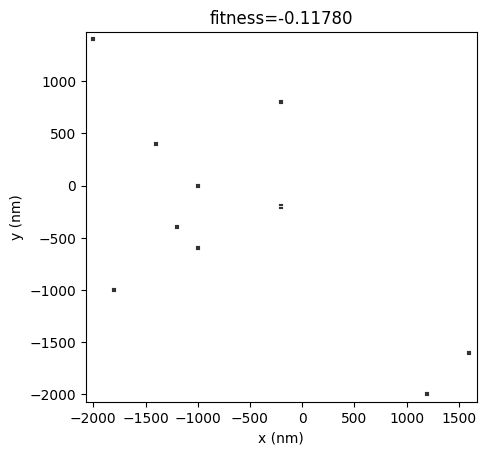

In [3]:
# ------- define main simulation
## geometry: single small gold rectangle (20x20x10 nm^3)
step = 20
material = materials.gold()
geometry = structures.rect_wire(step, L=2, W=2, H=2)
geometry = structures.center_struct(geometry)
struct = structures.struct(step, geometry, material)

## environment: air
n1 = 1.0
dyads = propagators.DyadsQuasistatic123(n1=n1)


## illumination: local quantum emitter (dipole source)
field_generator = fields.dipole_electric    # light-source: dipolar emitter
kwargs = dict(x0=0, y0=0, z0=step,          # position: center, "steps" above surface
              mx=0, my=1, mz=0,             # orientation: Y
              R_farfield_approx=5000)       # use farfield approx. after 5microns
wavelengths = [800.]
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

## simulation object of single element
element_sim = core.simulation(struct, efield, dyads)


## -------- test the setup with 10 blocks
XY_coords_blocks = np.random.randint(-10, 10, 20) * 5
full_sim = setup_structure(XY_coords_blocks, element_sim)
cost = cost_direct_emission(XY_coords_blocks, element_sim, method='lu')
visu.structure(full_sim, tit='fitness={:.5f}'.format(cost))

## configure the optimization

Configure the number of plasmonic blocks and the position constraints in the nevergrad instrumentation

In [4]:
# ------- setup the parametrization
N_elements = 40
min_pos = -12
max_pos = 12
method = 'lu'

## Running optimization

Now we run the optimization. Because this notebook is for illustration and the problem is relatively heavy, we evaluate a optimizer on a small computation budgets here. We provide a second script that runs several optimizer runs in parallel via MPI. A third script reloads and plots these results. Please have a look.

In [5]:
budget = 1000     # stop criterion: allowed number of evaluations
N_repet_each = 1   # how often to repeat the run with each optimizer

# iterate through list of algorithms to use
list_optims = ["NGOpt"]

# init results container dict
hist_cost = {}
hist_best_f = {}
hist_best_x = {}
for optim_name in list_optims:
    hist_cost[optim_name] = []
    hist_best_f[optim_name] = []
    hist_best_x[optim_name] = 0

# perform optimizations
for optim_name in list_optims:
    print('running optimizer: "{}"'.format(optim_name))

    # run the optimizer multiple times
    for k in range(N_repet_each):
        print('repetition {}/{}'.format(k+1, N_repet_each))
        
        # discrete integer parametrization (positions on a grid)
        args_geo_ng = ng.p.Tuple(
            *[ng.p.Scalar(lower=min_pos, upper=max_pos
                        ).set_integer_casting() 
                    for i in range(2*N_elements)]
            )

        # wrap free and fixed arguments
        instru = ng.p.Instrumentation(
            x=args_geo_ng,   # optimized args
            
            element_sim=element_sim, # fixed kwargs
            method=method,
        )
        
        # initialize the optimizer
        optimizer = ng.optimizers.registry[optim_name](instru, budget)
        
        # init tracking values
        best_f = float("inf") # container for best solution
        yval = []             # container for convergence curve
        
        # the actual optimization loop
        pbar = tqdm(range(budget))
        for k in pbar:
            pbar.set_description("best cost: {:.3f}".format(best_f))
            x = optimizer.ask()   # get suggestion for new test structure

            y = cost_direct_emission(**x.value[1]) # eval. the optimizer's suggestion
            optimizer.tell(x, y)  # tell the cost to the optimizer
            
            if y < best_f:
                best_f = y
                hist_best_x[optim_name] = x
            yval.append(best_f)
    
        # add results of run to history
        hist_cost[optim_name].append(yval)
        hist_best_f[optim_name].append(best_f)


running optimizer: "NGOpt"
repetition 1/1


best cost: -0.478: 100%|██████████| 1000/1000 [13:54<00:00,  1.20it/s]


## Best structure from each algo

timing for wl=800.00nm - setup: EE 25.4ms, inv.: 53.4ms, repropa.: 4.7ms (1 field configs), tot: 83.6ms


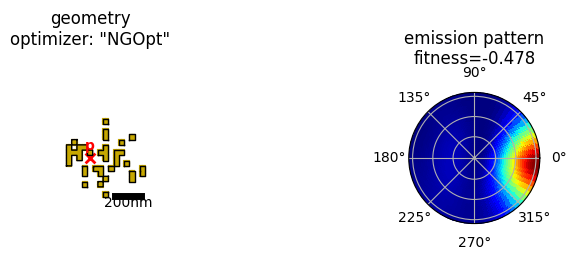

In [6]:
for i, optim_name in enumerate(list_optims):
    ## --- resimulate best individual
    x = hist_best_x[optim_name]
    f = np.min(hist_best_f[optim_name])
    sim = setup_structure(x.kwargs['x'], element_sim)
    sim.scatter(method=method)
    
    teta, phi, I_sc, I_tot, I0 = linear.farfield(
            sim, field_index=0,
            tetamin=0, tetamax=np.pi/2,
            Nteta=32, Nphi=72)
    
    ## --- plot
    plt.figure(figsize=(8,3))

    ## - structure geometry
    plt.subplot(121, aspect='equal')
    plt.title('geometry\noptimizer: "{}"'.format(optim_name), y =1.3)
    plt.axis('off')

    # structure
    visu.structure(sim, color='#c7a800', scale=1, show=False)
    visu.structure_contour(sim, color='k', show=False)
    # emitter position
    plt.text(sim.efield.kwargs['x0'], sim.efield.kwargs['y0']+20, 
                                        r"$\mathbf{p}$", ha='center', va='bottom', color='r')
    plt.scatter([sim.efield.kwargs['x0']], [sim.efield.kwargs['y0']],
                                        marker='x', linewidth=2, s=50, color='r')
    # scale bar
    bnds = [sim.struct.geometry.T[0].max(), sim.struct.geometry.T[1].min(), sim.struct.geometry.T[1].max()]
    plt.text(bnds[0]-120, bnds[1] - 0.18*(bnds[2]-bnds[1]), 
             "200nm", ha='center', va='bottom')
    plt.plot([bnds[0]-220, bnds[0]-20], 
             [bnds[1], bnds[1]], lw=5, color='k', clip_on=False)
    plt.xlim(-500,500)
    plt.ylim(-500,500)
    ## - emission pattern
    plt.subplot(122, polar=True)
    plt.title("emission pattern\nfitness={:.3g}".format(f), x=0.5, y=1.15)
    im = visu.farfield_pattern_2D(teta, phi, I_tot,
                              cmap='jet', degrees=False, show=False)
    plt.gca().set_yticklabels([])

    plt.tight_layout()
    plt.show()

## Optimizer convergence plot

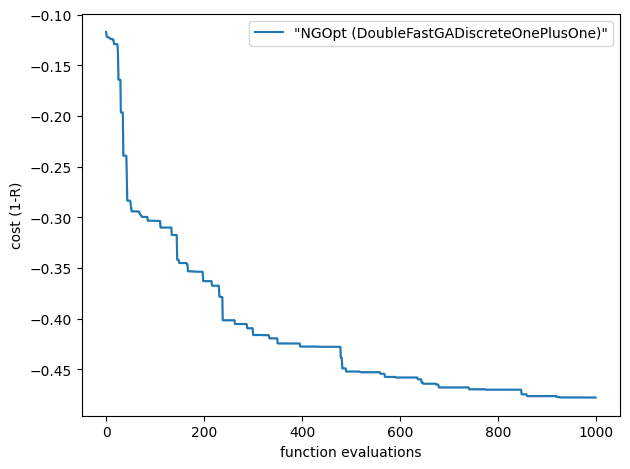

In [7]:
colors = [f'C{i}' for i in range(10)]

for i_opt, k in enumerate(hist_cost):
    for i, convergence in enumerate(hist_cost[k]):
        plt.plot(convergence, color=colors[i_opt], lw=0.5, alpha=0.5, dashes=[4,4])
    
    tit = k if k!='NGOpt' else 'NGOpt ({})'.format(optimizer.optim.name)
    plt.plot(np.median(hist_cost[k], axis=0), color=colors[i_opt], label=f'"{tit}"')
    plt.fill_between(np.arange(len(hist_cost[k][0])), 
                     np.quantile(hist_cost[k], 0.25, axis=0), 
                     np.quantile(hist_cost[k], 0.75, axis=0), 
                     color=colors[i_opt],
                     alpha=0.25)

# plt.xscale('log')

plt.xlabel('function evaluations')
plt.ylabel('cost (1-R)')
plt.legend()

plt.tight_layout()
plt.show()